# Анализ воронки продаж и A/A/B-тестирование мобильного приложения.

<div style="border:solid Blue 2px; padding: 20px">
       
Перед нами данные об активности пользователей мобильного приложения магазина продуктов питания. Мы располагаем логами, которые содержат следующую информацию: 
* название события;
* уникальный идентификатор пользователя;
* время события;
* номер эксперимента.
       
Наши задачи: 
1. изучить воронку продаж, чтобы узнать, как и сколько пользователей доходит до покупки, на каких этапах они «застревают»;
2. провести A/A/B-тестирование, чтобы проверить гипотезу об изменении шрифтов. 
</div>

## Шаг 1. Знакомство с данными

Импортируем библиотеки и загрузим датасет.

In [202]:
%pip install plotly
%pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import math as mth
import scipy.stats as st
import datetime as dt
from pandas.plotting import register_matplotlib_converters
sns.set_palette('Spectral')
pd.plotting.register_matplotlib_converters()
from IPython.display import HTML

In [203]:
df_logs = pd.read_csv('logs_exp.csv', sep='\t')

Выведем общую информацию о датасете с помощью функции.

In [204]:
def display_data(data,name):
    print('*** Информация о датасете',name,'***')
    print()
    data.info()
    display(data.describe())
    display(data.sample(n=5)) 
    print('-'*80)
    print()
    
display_data(df_logs,'df_logs')

*** Информация о датасете df_logs ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.5+ MB


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


,EventName,DeviceIDHash,EventTimestamp,ExpId
211132,MainScreenAppear,2018079118824500896,1565121610,246
144695,OffersScreenAppear,7648005088289827166,1564985395,246
108715,MainScreenAppear,2729404905328132990,1564888806,248
187644,OffersScreenAppear,5515378553085864642,1565083576,247
178089,PaymentScreenSuccessful,3337471580007169353,1565061481,246


--------------------------------------------------------------------------------



### Вывод

1. в таблице df_logs 4 столбца с логами пользователей, каждая запись в логе — это действие пользователя, или событие:
    * EventName — название события;
    * DeviceIDHash — уникальный идентификатор пользователя;
    * EventTimestamp — время события;
    * ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
* пропусков нет;
* нужна замена типа данных для времени и id;
* название столбцов поменяем на более удобные;
* названия событий нужно поменять на более удобные.

## Шаг 2. Подготовка данных

Поменяем названия столбцов для удобства обращения к ним.

In [205]:
df_logs = df_logs.rename(
    columns={'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_ts', 'ExpId':'test_id'})

Поменяем тип данных для столбца с id пользователя.

In [206]:
df_logs['user_id'] = df_logs['user_id'].astype('object')

Поменяем тип данных для столбца с датой.

In [207]:
df_logs['event_ts'] = pd.to_datetime(df_logs['event_ts'], unit='s')

Посмотрим на уникальные названия событий.

In [208]:
df_logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Заменим их на более удобные для восприятия.

In [209]:
df_logs['event_name'] = df_logs['event_name'].replace(
    {'MainScreenAppear':'main_screen', 'PaymentScreenSuccessful':'payment_success', 'CartScreenAppear':'cart_screen',
       'OffersScreenAppear':'offers_screen', 'Tutorial':'tutorial'})

Проверим датасет на наличие дубликатов.

In [210]:
print('Количество дубликатов df_logs -', df_logs.duplicated().sum(),\
     ', что составляет {:.2%}'.format(df_logs.duplicated().sum()/len(df_logs)))

Количество дубликатов df_logs - 413 , что составляет 0.17%


In [211]:
display((df_logs[df_logs.duplicated(keep=False)]).head())

,event_name,user_id,event_ts,test_id
452,main_screen,5613408041324010552,2019-07-30 08:19:44,248
453,main_screen,5613408041324010552,2019-07-30 08:19:44,248
2348,cart_screen,1694940645335807244,2019-07-31 21:51:39,248
2350,cart_screen,1694940645335807244,2019-07-31 21:51:39,248
3572,main_screen,434103746454591587,2019-08-01 02:59:37,248


Обнаружено 413 дубликатов, что составляет 0,17% от всего датасета. Возможно, они появились из-за перезагрузки страницы. Поскольку, одно и то же событие не могло произойти дважды в секунду для одного и того же пользователя, мы удалим дублирующие строки. 

In [212]:
df_logs = df_logs.drop_duplicates(keep='first')

Добавим отдельный столбец с датой.

In [213]:
df_logs['event_dt'] = df_logs['event_ts'].dt.date

Проверим результат предобработки.

In [214]:
display_data(df_logs,'df_logs')

*** Информация о датасете df_logs ***

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  object        
 2   event_ts    243713 non-null  datetime64[ns]
 3   test_id     243713 non-null  int64         
 4   event_dt    243713 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 8.4+ MB


,event_ts,test_id
count,243713,243713.000000
mean,2019-08-04 10:19:17.987665920,247.022161
min,2019-07-25 04:43:36,246.000000
25%,2019-08-02 14:36:45,246.000000
50%,2019-08-04 11:51:00,247.000000
75%,2019-08-06 06:56:24,248.000000
max,2019-08-07 21:15:17,248.000000
std,NaN,0.824420


,event_name,user_id,event_ts,test_id,event_dt
113564,offers_screen,4803696345496667929,2019-08-04 07:55:41,246,2019-08-04
179824,main_screen,6362934087118134085,2019-08-06 05:03:40,248,2019-08-06
171744,payment_success,2772044537339378962,2019-08-05 18:05:23,248,2019-08-05
148397,main_screen,7188522580408167660,2019-08-05 08:34:41,247,2019-08-05
103784,offers_screen,1721101105509587254,2019-08-03 18:21:19,247,2019-08-03


--------------------------------------------------------------------------------



### Вывод

Изменены названия столбцов и событий.

Изменены типы данных для даты и id.

Обработаны дубликаты. Обнаружено 413 дубликатов, что составляет 0,17% от всего датасета. Возможно, они появились из-за перезагрузки страницы. Поскольку, одно и то же событие не могло произойти дважды в секунду для одного и того же пользователя, мы удалили дублирующие строки. 

## Шаг 3. Анализ данных

__Посмотрим, сколько всего событий в логе.__

In [215]:
print('В логе', df_logs['event_ts'].count(), 'событий.')

В логе 243713 событий.


__Посмотрим, сколько всего пользователей в логе.__

In [216]:
print('В логе', df_logs['user_id'].nunique(), 'уникальных пользователей.')

В логе 7551 уникальных пользователей.


__Посмотрим, сколько в среднем событий приходится на пользователя.__

In [217]:
events_per_user = df_logs.pivot_table(index='user_id', values='event_ts',aggfunc='count').reset_index()
display(events_per_user.head())

,user_id,event_ts
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


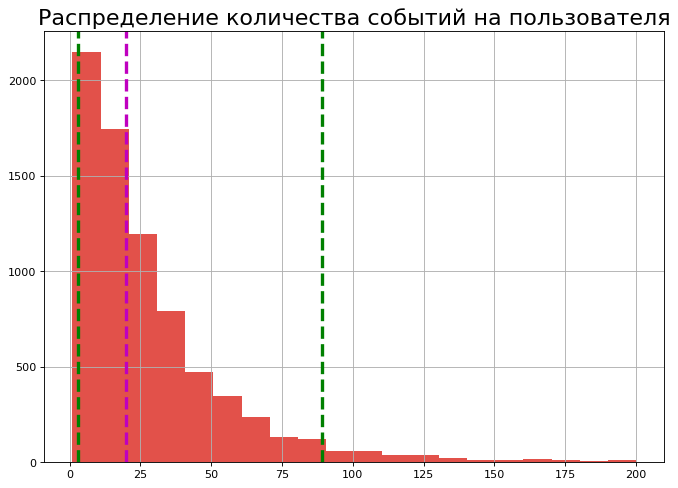

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_ts, dtype: float64

0    5
Name: event_ts, dtype: int64

np.float64(3.0)

np.float64(89.0)

In [218]:
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(events_per_user['event_ts'], bins=20,range=(events_per_user['event_ts'].min(),200)) 
plt.title('Распределение количества событий на пользователя',fontsize=20)
plt.axvline(x=events_per_user['event_ts'].median(),   
                linewidth=3,   
                color='m',  
                linestyle='--')
plt.axvline(x=events_per_user['event_ts'].quantile(.05),   
                linewidth=3, 
                color='g', 
                linestyle='--')
plt.axvline(x=events_per_user['event_ts'].quantile(.95),   
                linewidth=3, 
                color='g', 
                linestyle='--')
plt.grid();
plt.show();
display(events_per_user['event_ts'].describe());
display(events_per_user['event_ts'].mode());
display(events_per_user['event_ts'].quantile(.05));
display(events_per_user['event_ts'].quantile(.95));

На гистограмме видно скошенность распределения влево, это значит, что есть длинный хвост со стороны больших значений.
Медиана приходится на значение - 20, среднее - 32, а мода - 5. 
Минимальное (1) и максимальное (2307) значения выглядят подозрительно.
95 перцентиль приходится на значение 89, значит, как минимум 5% пользователей совершили 89 или более событий.

При таком характере распределения будем использовать моду в качестве среднего значения. __Среднее количество событий на пользователя равно 5.__ Этого количества достаточно для совершения заказа.

__Посмотрим на период, за который собраны данные.__

In [219]:
print(df_logs['event_ts'].min())
print(df_logs['event_ts'].max())

2019-07-25 04:43:36
2019-08-07 21:15:17


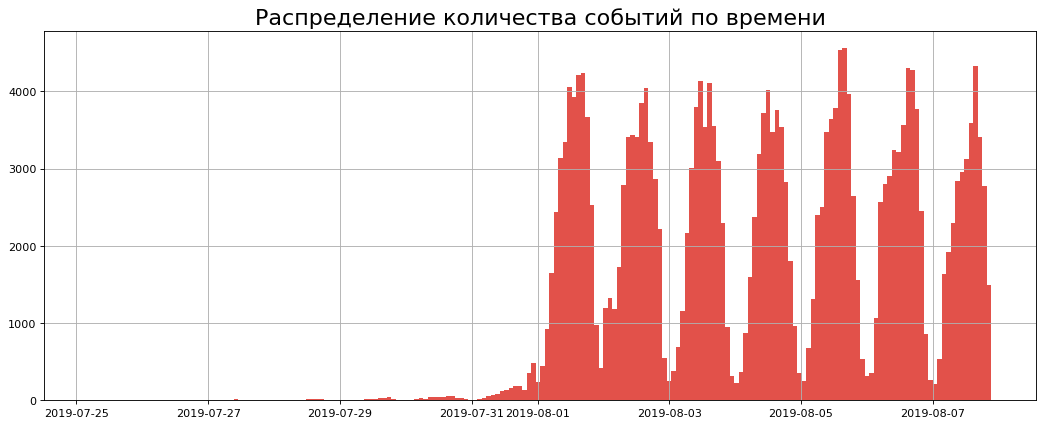

In [220]:
plt.figure(figsize=(16,6), dpi= 80)
plt.hist(df_logs['event_ts'], bins=200)
plt.title('Распределение количества событий по времени',fontsize=20)
plt.grid();
plt.show();

Нам предоставлены данные за 2 недели - с 25.07.19 по 07.08.19. Но до 01.08.19 количество событий очень мало. Вероятно, это завершающие события по предыдущим периодам.

__Оставим в датасете только данные с 01.08.19 и проверим, насколько изменилось количество уникальных пользователей и общее число событий.__

In [221]:
df_logs_1 = df_logs.query('event_ts >= "2019-08-01 00:00:00"')

In [222]:
print('В новом срезе', df_logs_1['user_id'].nunique(), 'уникальных пользователей.')

В новом срезе 7534 уникальных пользователей.


In [223]:
print('В новом срезе', df_logs_1['event_ts'].count(), 'событий.')

В новом срезе 240887 событий.


In [224]:
users_delta = df_logs['user_id'].nunique()-df_logs_1['user_id'].nunique()
events_delta = df_logs['event_ts'].count()-df_logs_1['event_ts'].count()

print('Потеряно', users_delta, 'пользователей, что составляет {:.2%}'\
      .format(users_delta/df_logs['user_id'].nunique()))

print('Потеряно', events_delta, 'событий, что составляет {:.2%}'\
     .format(events_delta/df_logs['event_ts'].count()))

Потеряно 17 пользователей, что составляет 0.23%
Потеряно 2826 событий, что составляет 1.16%


__Проверим, остались ли у нас 3 тестовые группы.__

In [225]:
df_logs_1['test_id'].unique()

array([246, 247, 248], dtype=int64)

### Вывод


Данные собраны за 2 недели - с 25 июля 2019 по 07 августа 2019. Но до 01.08.19 количество событий очень мало. Вероятно, это завершающие события по предыдущим периодам. Полные данные есть всего за 1 неделю - с 01 августа 2019 по  07 августа 2019.

Количество событий в логе - 243713, после корректировки периода осталось - 240887.

Количество уникальных пользователей - 7551, после корректировки периода осталось - 7534.

Отбросив старые данные, мы потеряли лишь малую часть пользователей и событий: 
    17 пользователей - 0.23%;
    2826 событий - 1.16%.
    
В столбце test_id сохранились 3 тестовые группы - 246, 247, 248.

Среднее количество событий на пользователя по моде равно 5. За 5 событий вполне можно совершить заказ, это хороший знак.

Нужно будет подробнее анализировать пользователей с аномальными значениями. 2307 событий за 2 недели - это очень много (примерно 164 события в день). Наш полный цикл событий не превышает 5, значит это примерно 32 полных цикла в день. Возможно, это оптовые пользователи, которые долго собирают заказ и часто обновляют страницу с каталогом. 1 событие могло появится, если пользователь случайно попал на сайт или не нашел необходимый товар на главной странице.

## Шаг 4. Воронка событий

__Посмотрим, какие события есть в логах, и как часто они встречаются.__

In [226]:
pd.DataFrame(round((
    df_logs_1['event_name'].value_counts().sort_values(ascending=False)),2)).style.background_gradient('Spectral')

,count
event_name,
main_screen,117328
offers_screen,46333
cart_screen,42303
payment_success,33918
tutorial,1005


Всего в логах встречается 5 видов событий:
 * main_screen - главная страница;
 * offers_screen - страница товара;
 * cart_screen - корзина;
 * payment_success - подтверждение оплаты;
 * tutorial	- справка. 
 
Чаще всего встречается главная страница - 117328, справка на последнем месте - 1005.
Результат выглядит логично, многие видят главную страницу и после этого уходят. О существовании справки пользователи могут даже не знать.

__Посмотрим, сколько уникальных пользователей совершали каждое из этих событий и посчитаем долю от общего числа уникальных пользователей.__

In [227]:
event_name_group = df_logs_1.groupby('event_name')['user_id'].nunique().reset_index()
event_name_group['user_part'] = event_name_group['user_id'] / df_logs_1['user_id'].nunique() 
pd.DataFrame(round((event_name_group.sort_values(by='user_id',ascending=False)),2)).style.background_gradient('Spectral')

,event_name,user_id,user_part
1,main_screen,7419,0.980000
2,offers_screen,4593,0.610000
0,cart_screen,3734,0.500000
3,payment_success,3539,0.470000
4,tutorial,840,0.110000


Главную страницу видят 98% уникальных пользователей, значит 2% приходят по ссылкам из сторонних источников.
На страницу товара попадает 61% уникальных пользователей, в корзину заходит 50% уникальных пользователей, на странице подтверждения товара оказывается 47% уникальных пользователей. 

Справку просмотрело 11% уникальных пользователей. Этот шаг не нужен для совершения заказа.

In [228]:
df_logs_2 = df_logs_1.query('event_name != "tutorial"')

В дальнейшем не будем рассматривать событие "справка".
Последовательность событий выгладит следующим образом:

__Главная страница >> страница товара >> корзина >> подтверждение оплаты.__

__Построим строгую событийную воронку с учетом последовательности событий.__

Напишем функцию, которая считает, сколько пользователей переходит на каждый следующий этап, учитывая последовательность событий.

In [229]:
def my_funnel(data, name, title):
    users = data.pivot_table(
    index='user_id', columns='event_name', values='event_ts', aggfunc='min') 

    step_1 = ~users['main_screen'].isna()
    step_2 = step_1 & (users['offers_screen'] > users['main_screen'])
    step_3 = step_2 & (users['cart_screen'] > users['offers_screen'])
    step_4 = step_3 & (users['payment_success'] > users['cart_screen'])

    n_total = data['user_id'].nunique()
    n_main_screen = users[step_1].shape[0]
    n_offers_screen = users[step_2].shape[0]
    n_cart_screen = users[step_3].shape[0]
    n_payment_success = users[step_4].shape[0]

    part_main_screen = (n_main_screen / n_total) *100
    part_offers_screen = (n_offers_screen / n_main_screen) *100
    part_cart_screen = (n_cart_screen / n_offers_screen) *100
    part_payment_success = (n_payment_success / n_cart_screen) *100
    
    print('Событийная воронка для',title)
    print('-'*45)
    print('Посетили главную страницу:', n_main_screen, '-', round(part_main_screen,2), '%')
    print('Перешли на страницу товара:', n_offers_screen, '-', round(part_offers_screen,0), '%')
    print('Добавили товар в корзину:', n_cart_screen, '-', round(part_cart_screen,0), '%')
    print('Оплатили:', n_payment_success, '-', round(part_payment_success,0), '%')
    print('Прошли от первого до финального этапа:', n_payment_success, '-', round((n_payment_success/n_total)*100,2), '%')
    steps = [
        'Всего посетителей', 'Посетили главную страницу','Перешли на страницу товара','Добавили товар в корзину','Оплатили']
    values = [n_total, n_main_screen, n_offers_screen, n_cart_screen, n_payment_success]
    
    fig = go.Figure()
    fig.add_trace(go.Funnel(x=values, y=steps, textposition='inside', textinfo = 'value+percent previous'))
    fig.update_layout(title_text='Строгая событийная воронка для '+title, title_xanchor='auto', title_xref='paper')

    fig.write_html(f'{name}.html',full_html=False, include_plotlyjs='cdn')
    display(HTML(filename=f'{name}.html'));

In [230]:
my_funnel(df_logs_1, 'df_logs_1', 'всего датасета.')

Событийная воронка для всего датасета.
---------------------------------------------
Посетили главную страницу: 7419 - 98.47 %
Перешли на страницу товара: 4201 - 57.0 %
Добавили товар в корзину: 1767 - 42.0 %
Оплатили: 454 - 26.0 %
Прошли от первого до финального этапа: 454 - 6.03 %


98% пользователей попадает на главную страницу.

57% пользователей переходит с главной страницы на страницу товара. Возможно, они не нашли ничего нужного для себя или их что-то не устроило (например, цена). А возможно, они попали в приложение по ошибке (ошиблись ссылкой). Стоит провести функциональное тестирование гланой страницы, чтобы исключить технические неполадки (не работает поиск, не работают ссылки на товар и т.п.).

42% пользователей переходит со страницы товара в корзину. Отток может произойти, если пользователь узнал о товаре больше информации и передумал (плохие отзывы, нет нужного объема или вкуса).

26% пользователей из корзины совершает оплату. Отток может произойти, если покупателя не устроила стоимость доставки, если сумма заказа превысила его ожидания (или наоборот - недобрал до минимальной суммы заказа), если его адрес не входит в зону доставки, если не сработал промокод, если потребовалось указать много личных данных, если оплата не прошла (сбой, закончились деньги).

__Теперь построим нестрогую событийную воронку.__

In [231]:
def my_funnel_1(data, name, title):
    users = data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
    n_users_total = data['user_id'].nunique()
    n_users_list = users['user_id'].to_list()
    n_users_list.append(n_users_total)
    values=sorted(n_users_list,reverse = True)
    steps = ['Всего посетителей','Посетили главную страницу','Перешли на страницу товара',\
    'Добавили товар в корзину','Оплатили']

    fig = go.Figure()
    fig.add_trace(go.Funnel(x=values, y=steps, textposition='inside', textinfo = 'value+percent previous',
                           marker = {"color": ["#3399FF", "#00CCFF","#0099CC", "#00CCCC", "teal" ]}))
    fig.update_layout(title_text='Нестрогая событийная воронка для '+title, title_xanchor='auto', title_xref='paper')

    fig.write_html(f'{name}.html',full_html=False, include_plotlyjs='cdn')
    display(HTML(filename=f'{name}.html'));

In [232]:
my_funnel_1(df_logs_2, 'df_logs_2', 'всего датасета.')

Анализ нестрогой воронки показывает, что больше всего пользователей теряется при переходе с главной страницы на страницу товара. Это говорит о том, что пользователь не заинтересовался нашими предложениями настолько, чтобы сразу перейти дальше.

На страницу товара переходит 62% от количества пользователей, которые были на главной странице.

В корзине оказывается 81% от количества пользователей, которые были на странице товара.

К оплате переходит 95% от количества пользователей, которые были на странице товара.

От первого до последнего события доходит 47% пользователей.

### Вывод

На последнем этапе (корзина >> оплата) происходит самый большой отток пользователей - 74% по строгой воронке и всего 5% по нестрогой. 
Отток может произойти, если покупателя не устроила стоимость доставки, если сумма заказа превысила его ожидания (или наоборот - недобрал до минимальной суммы заказа), если его адрес не входит в зону доставки, если не сработал промокод, если потребовалось указать много личных данных, если оплата не прошла (сбой, закончились деньги).

На переходе со страницы товара в корзину теряется: 58% пользователей по строгой воронке и 19% по нестрогой. Отток может произойти, если пользователь узнал о товаре больше информации и передумал (плохие отзывы, нет нужного объема или вкуса).

На переходе с главной страницы на страницу товара теряется: 43% пользователей по строгой воронке и 38% по нестрогой. Возможно, они не нашли ничего нужного для себя или их что-то не устроило (например, цена). А возможно, они попали в приложение по ошибке (ошиблись ссылкой). Стоит провести функциональное тестирование гланой страницы, чтобы исключить технические неполадки (не работает поиск, не работают ссылки на товар и т.п.).

От первого до финального этапа доходит всего 6% пользователей по строгой воронке и 47% по нестрогой.

Мы провели строгий и нестрогий анализ событийной воронки. Различия между ними позволяют увидеть этапы, на которых пользователи действуют не по нашему плану. Это связано с разнообразием источников привлечения клиентов, некоторые пользователи приходят из рекалмных источников сразу на страницу товара, многие приходят в ранее составленную корзину по уведомлению. Сильнее всего различия заметны на этапе "корзина >> оплата". Возможно, переход на страницу платежной системы для оформления платежа рассматривается как отдельное событие, которое пропущено в наших данных.

## Шаг 5. А/А/В-тест

__Посмотрим на количество уникальных пользователей в каждой из тестовых групп.__

In [233]:
test_user_group = df_logs_1.groupby('test_id')['user_id'].nunique().reset_index()
display(test_user_group)

,test_id,user_id
0,246,2484
1,247,2513
2,248,2537


У нас есть 3 группы с примерно одинаковым количеством уникальных пользователей.

Группы 246 и 247 — контрольные, а 248 — экспериментальная.

__План проверки гипотез__

У нас есть 4 значимых события:
    1. переход на главную страницу;
    2. переход на страницу товара;
    3. переход в корзину;
    4. совершение оплаты.
Нам нужно будет сравнить доли конверсии в каждое из этих событий несколько раз:
    1. между контрольными группами 246 и 247;
    2. между контрольной группой 246 и экспериментальной 248; 
    3. между контрольной группой 247 и экспериментальной 248;
    4. между объединенной контрольной (246+247) и экспериментальной 248.

Таким образом, на одной выборке будет протестировано 16 гипотез.
Для снижения вероятности ложноположительного результата эксперимента воспользуемся поправкой Бонферрони и разделим выбранный уровень альфа на 16.

Критически значимым признан уровень альфа в 0,003(0,05/16) - это значит, что статистически значимыми признаются результаты, когда вероятность совершить ошибку первого рода (отвергнуть верную гипотезу) составляет меньше 0,3%.

Для проверки статистической значимости долей будет проводиться z-тест.

<div style="border:solid Green 2px; padding: 40px">
    
Нам нужно определить, различаются ли доли конверсий в 2 группах.
     

 Сформулируем нулевую гипотезу:

__H0 = доли конверсий в группах не имеют значимых различий.__
     

 Соответственно, альтернативная гипотеза:

__H1 = доли конверсий в группах имеют значимые различия.__
    </div>

__Проведем А/А-тест и проверим, есть ли различия между контрольными группами 246 и 247.__

In [234]:
df_logs_246 = df_logs_1.query('test_id == 246')
df_logs_247 = df_logs_1.query('test_id == 247')
n_user_246 = df_logs_246['user_id'].nunique()
n_user_247 = df_logs_247['user_id'].nunique()

In [235]:
my_funnel_1(df_logs_246, 'df_logs_246', 'группы 246')

In [236]:
my_funnel_1(df_logs_247, 'df_logs_247', 'группы 247')

Напишем функцию для проведения z-теста на сравнение долей.

In [237]:
def z_test_1(data1, data2, event):
    
    alpha = 0.003 #критический уровень статистической значимости
    
    users1 = data1.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
    users2 = data2.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
    
    step1_1 = data1['user_id'].nunique()
    step1_2 = data2['user_id'].nunique()
    step_n_1 = users1[event]
    step_n_2 = users2[event]
    
    
    successes = np.array([step_n_1, step_n_2]) #количество пользователей на исследуемом шаге
    trials = np.array([step1_1, step1_2]) #количество пользователей на 1 шаге

    p1 = successes[0]/trials[0] #пропорция успехов в первой группе

    p2 = successes[1]/trials[1] #пропорция успехов во второй группе

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) #пропорция успехов в комбинированном датасете:

    difference = p1 - p2 #разница пропорций в датасетах

    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha: print(
        'Отвергаем нулевую гипотезу: между долями есть значимая разница') 
    else: print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [238]:
#cравним доли перешедших на 1 шаг - главная страница

z_test_1(df_logs_246, df_logs_247, 'main_screen')

#cравним доли перешедших на 2 шаг - страницу товара

z_test_1(df_logs_246, df_logs_247, 'offers_screen')

#cравним доли перешедших на 3 шаг - в корзину

z_test_1(df_logs_246, df_logs_247, 'cart_screen')

#равним доли перешедших на 4 шаг - подтверждение оплаты

z_test_1(df_logs_246, df_logs_247, 'payment_success')

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Тест показал, что статистически значимых различий между группами 246 и 247 не обнаружно. Значит, разбиение на группы проведено корректно, и все обнаруженные отличия между контрольной и экспериментальной группами будут свидетельствовать о влиянии эксперимента на поведение пользователей.

Теперь можем продолжать исследование. Переходим к А/В-тесту.

__Проведем А/B-тест и проверим, есть ли различия между контрольной группой 246 и тестовой 248.__

In [239]:
df_logs_248 = df_logs_1.query('test_id == 248')
n_user_248 = df_logs_248['user_id'].nunique()
my_funnel_1(df_logs_248, 'df_logs_248', 'группы 248')

In [240]:
#cравним доли перешедших на 1 шаг - главная страница

z_test_1(df_logs_246, df_logs_248, 'main_screen')

#cравним доли перешедших на 2 шаг - страницу товара

z_test_1(df_logs_246, df_logs_248, 'offers_screen')

#cравним доли перешедших на 3 шаг - в корзину

z_test_1(df_logs_246, df_logs_248, 'cart_screen')

#равним доли перешедших на 4 шаг - подтверждение оплаты

z_test_1(df_logs_246, df_logs_248, 'payment_success')

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


__Проверим, есть ли различия между контрольной группой 247 и тестовой 248.__

In [241]:
#cравним доли перешедших на 1 шаг - главная страница

z_test_1(df_logs_248, df_logs_247, 'main_screen')

#cравним доли перешедших на 2 шаг - страницу товара

z_test_1(df_logs_248, df_logs_247, 'offers_screen')

#cравним доли перешедших на 3 шаг - в корзину

z_test_1(df_logs_248, df_logs_247, 'cart_screen')

#равним доли перешедших на 4 шаг - подтверждение оплаты

z_test_1(df_logs_248, df_logs_247, 'payment_success')

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


__Проверим, есть ли различия между объединенной контрольной группой (493) и тестовой 248.__

In [242]:
df_logs_493 = df_logs_1.query('test_id == 246 or test_id == 247')
n_user_493 = df_logs_493['user_id'].nunique()
my_funnel_1(df_logs_493, 'df_logs_493', 'объединенной контрольной группы')

In [243]:
#cравним доли перешедших на 1 шаг - главная страница

z_test_1(df_logs_493, df_logs_248, 'main_screen')

#cравним доли перешедших на 2 шаг - страницу товара

z_test_1(df_logs_493, df_logs_248, 'offers_screen')

#cравним доли перешедших на 3 шаг - в корзину

z_test_1(df_logs_493, df_logs_248, 'cart_screen')

#равним доли перешедших на 4 шаг - подтверждение оплаты

z_test_1(df_logs_493, df_logs_248, 'payment_success')

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Вывод

Мы провели тестирование доли переходов на каждое событие в контрольных группах, а затем между контрольными и тестой группами.
Статистически значимых различий между долями не обнаружено.

Делаем вывод, что изменения в тестовой группе не оказали влияния на поведение пользователей.

## Шаг 6. Общий вывод

<div style="border:solid Blue 2px; padding: 20px">
    
1. Данные собраны за 2 недели - с 25 июля 2019 по 07 августа 2019. Но до 01.08.19 количество событий очень мало. Вероятно, это завершающие события по предыдущим периодам. __Полные данные есть всего за 1 неделю - с 01 августа 2019 по 07 августа 2019.__
За эту неделю количество событий в логе составило - 240887, а количество уникальных пользователей - 7534.
    
2. Среднее количество событий на пользователя (по моде) равно 5 - этого достаточно для совершения заказа.
    Минимальное (1) и максимальное (2307) значения выглядят подозрительно. Возможно, 2307 событий приходится на оптового пользователя, который долго собирает заказ и часто обновляет страницу с каталогом. 1 событие могло появится, если пользователь случайно попал на сайт или не нашел необходимы товар на главной странице.

3. На последнем этапе (корзина >> оплата) происходит самый большой отток пользователей - 74% по строгой воронке и всего 5% по нестрогой. 
Отток может произойти, если покупателя не устроила стоимость доставки, если сумма заказа превысила его ожидания (или наоборот - недобрал до минимальной суммы заказа), если его адрес не входит в зону доставки, если не сработал промокод, если потребовалось указать много личных данных, если оплата не прошла (сбой, закончились деньги).

На переходе со страницы товара в корзину теряется: 58% пользователей по строгой воронке и 19% по нестрогой. Отток может произойти, если пользователь узнал о товаре больше информации и передумал (плохие отзывы, нет нужного объема или вкуса).

На переходе с главной страницы на страницу товара теряется: 43% пользователей по строгой воронке и 38% по нестрогой. Возможно, они не нашли ничего нужного для себя или их что-то не устроило (например, цена). А возможно, они попали в приложение по ошибке (ошиблись ссылкой). Стоит провести функциональное тестирование гланой страницы, чтобы исключить технические неполадки (не работает поиск, не работают ссылки на товар и т.п.).

От первого до финального этапа доходит всего 6% пользователей по строгой воронке и 47% по нестрогой.

Мы провели строгий и нестрогий анализ событийной воронки. Различия между ними позволяют увидеть этапы, на которых пользователи действуют не по нашему плану. Это связано с разнообразием источников привлечения клиентов, некоторые пользователи приходят из рекалмных источников сразу на страницу товара, многие приходят в ранее составленную корзину по уведомлению. Сильнее всего различия заметны на этапе "корзина >> оплата". Возможно, переход на страницу платежной системы для оформления платежа рассматривается как отдельное событие, которое пропущено в наших данных.
    
4. Контрольные группы для тестирования отобраны корректно, значимых различий в А/А-тесте не обнаружено.   
    
5. Мы провели тестирование доли переходов на каждое событие между контрольными и тестовой группами. Статистически значимых различий между долями не обнаружено.

6. Делаем вывод, что __изменение шрифта не оказало существенного влияния на поведение пользователей.__ Значит, менять можно. А вот нужно ли это пользователям, будут ли они покупать больше, нужно проверять в следующих исследованиях.

    
    
</div>   
    